# 1. Environment Setup & Data Ingestion
This stage initializes the analytical environment. We load three core# 🏛️ Insight 2: The "Economic Sentinel" Model

**The Hypothesis:** Aadhaar updates are not just IT logs; they are **Real-Time Economic Signals**. By analyzing the *type* of update, we can decode the demographic DNA of every district.

**The Methodology:**
We separate the data into two distinct economic signals:
1.  **The "Labor Signal" (Adult Demographic Updates):** Proxies for **Migration**. (Workers updating addresses/phones upon moving for jobs).
2.  **The "Stability Signal" (Child Biometric Updates):** Proxies for **Residency**. (Families updating mandatory biometrics for children aged 5/15).

**The Metric:**
$$\text{Mobility Ratio} = \frac{\text{Labor Signal}}{\text{Stability Signal}}$$
* **Ratio > 5.0 (Labor Magnet):** Industrial Hubs (Housing demand).
* **Ratio < 1.0 (Residential Anchor):** Family Suburbs (School/Health demand). streams of Aadhaar data: 
* **Biometric Updates**, **Demographic Updates**, and **New Enrollments**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# 1. Load Data (Ensuring clean start)
try:
    df_bio = pd.read_csv('normalized_biometric1.csv')
    df_demo = pd.read_csv('normalized_demographic.csv')
    # Standardize Dates
    df_bio['date'] = pd.to_datetime(df_bio['date'], format='%d-%m-%Y', errors='coerce')
    df_demo['date'] = pd.to_datetime(df_demo['date'], format='%d-%m-%Y', errors='coerce')
    
    # Standardize District Names
    def clean_text(text):
        return text.lower().replace('_', ' ').strip() if isinstance(text, str) else text

    for df in [df_bio, df_demo]:
        df['state'] = df['state'].apply(clean_text)
        df['district'] = df['district'].apply(clean_text)
        
    print("Data Loaded & Cleaned.")

except Exception as e:
    print(f"Error Loading Data: {e}")

# 2. Extract The Signals
# Aggregating daily data to monthly signals per district
def extract_signal(df, col_name, signal_name):
    # Create Month column for seasonal analysis later
    df['month'] = df['date'].dt.to_period('M')
    return df.groupby(['state', 'district', 'month'])[col_name].sum().reset_index().rename(columns={col_name: signal_name})

# Signal A: Labor Migration (Adult Updates)
df_labor = extract_signal(df_demo, 'demo_age_17_', 'labor_signal')

# Signal B: Family Stability (Child Updates)
df_family = extract_signal(df_bio, 'bio_age_5_17', 'family_signal')

# 3. Merge Signals
df_sentinel = pd.merge(df_labor, df_family, on=['state', 'district', 'month'], how='inner')

print(f"Signals Extracted. Dataset Shape: {df_sentinel.shape}")
print(df_sentinel.head(3))

Data Loaded & Cleaned.
Signals Extracted. Dataset Shape: (4666, 5)
                         state district    month  labor_signal  family_signal
0  andaman and nicobar islands  nicobar  2025-03           360            178
1  andaman and nicobar islands  nicobar  2025-09           149             94
2  andaman and nicobar islands  nicobar  2025-10            50             36


In [2]:
# 1. Aggregate to District Level (Full Year Profile)
df_district_profile = df_sentinel.groupby(['state', 'district'])[['labor_signal', 'family_signal']].sum().reset_index()

# 2. Calculate Mobility Ratio
# Avoid division by zero by adding a small epsilon
df_district_profile['mobility_ratio'] = df_district_profile['labor_signal'] / (df_district_profile['family_signal'] + 1)

# 3. Classify Economic Zones
def classify_zone(ratio):
    if ratio > 5.0:
        return 'Labor Magnet (Industrial)'
    elif ratio < 1.0:
        return 'Residential Anchor (Family)'
    else:
        return 'Mixed Use Zone'

df_district_profile['zone_type'] = df_district_profile['mobility_ratio'].apply(classify_zone)

# 4. Export the Intelligence Report
df_district_profile.to_csv('district_economic_profile.csv', index=False)

print("District Profiling Complete.")
print("Report Saved: 'district_economic_profile.csv'")

# Preview Top Labor Magnets
print("\n--- TOP 5 LABOR MAGNETS (Highest Migration) ---")
print(df_district_profile.sort_values('mobility_ratio', ascending=False).head(5)[['district', 'zone_type', 'mobility_ratio']])

District Profiling Complete.
Report Saved: 'district_economic_profile.csv'

--- TOP 5 LABOR MAGNETS (Highest Migration) ---
    district                  zone_type  mobility_ratio
510  balotra  Labor Magnet (Industrial)      401.000000
522     deeg  Labor Magnet (Industrial)      147.750000
537  phalodi  Labor Magnet (Industrial)      147.000000
514   beawar  Labor Magnet (Industrial)      143.333333
50    bajali  Labor Magnet (Industrial)      112.428571


Visual Insight #1: The Economic Radar This scatter plot separates cities by their "Demographic DNA."

Top-Left (Red): Cities where workers come alone (Needs Housing).

Bottom-Right (Green): Cities where families settle (Needs Schools).

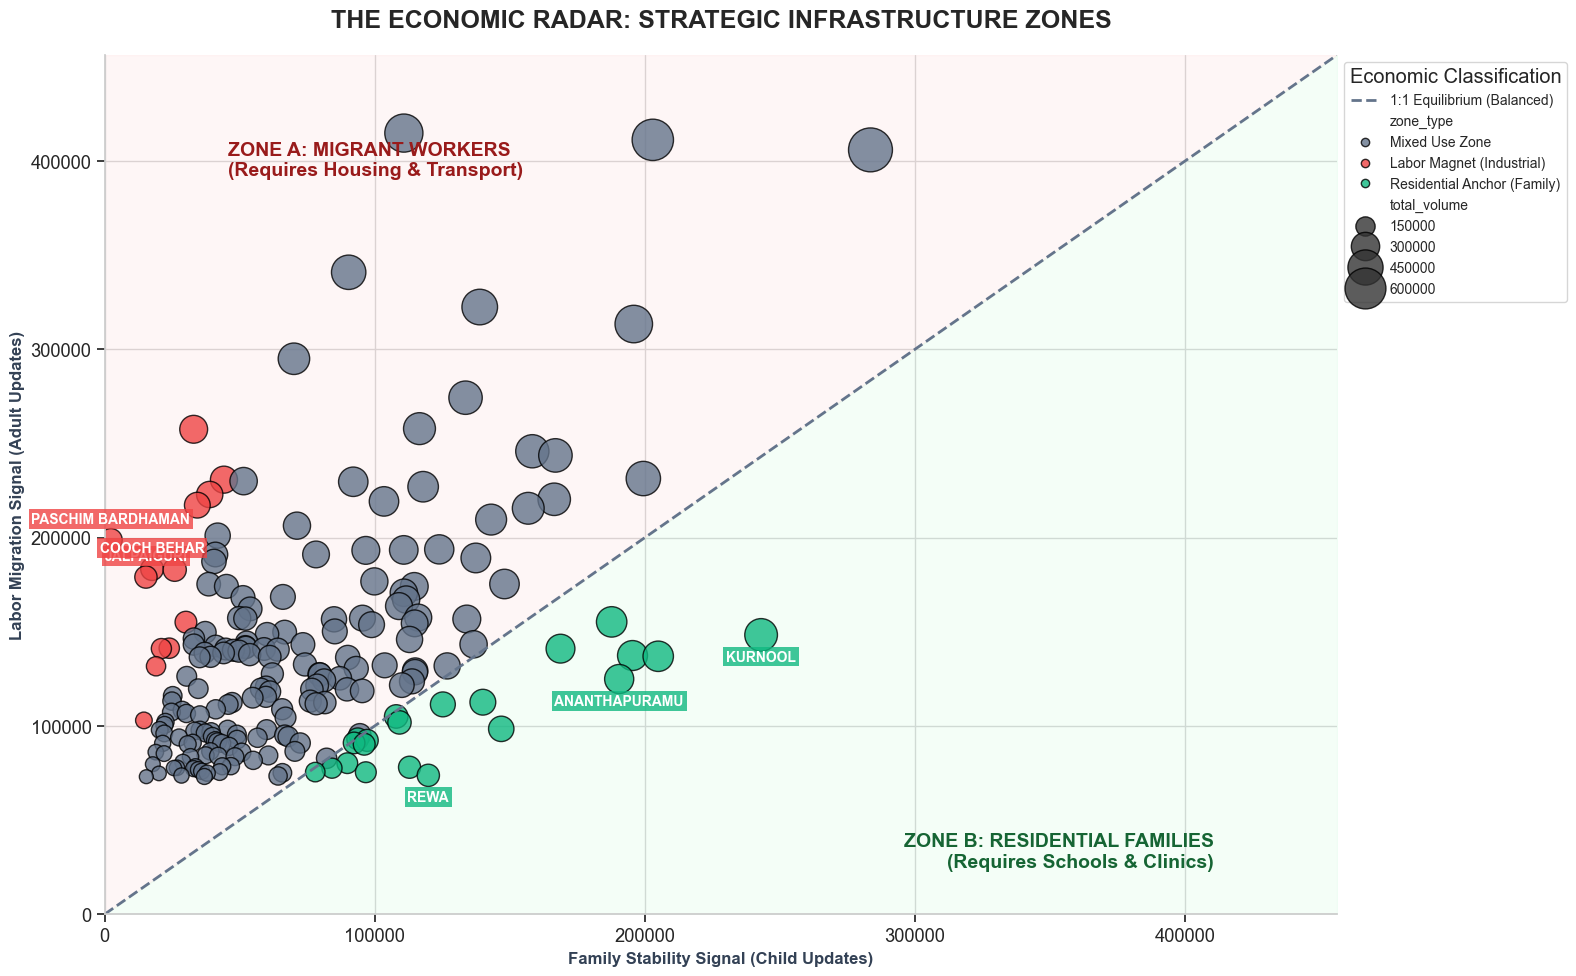

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_strategic_radar(df):
    # 1. Filter & Prepare Data
    # Only show relevant districts to avoid clutter (Top 200 by volume)
    df_plot = df.sort_values(by=['labor_signal', 'family_signal'], ascending=False).head(200).copy()
    
    # Define Total Volume for bubble size
    df_plot['total_volume'] = df_plot['labor_signal'] + df_plot['family_signal']

    # 2. Setup Canvas (Professional Style)
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_facecolor('white') # Clean background
    
    # 3. Create Strategic Zones (Background Shading)
    # Get max axis limit
    limit = max(df_plot['labor_signal'].max(), df_plot['family_signal'].max()) * 1.1
    
    # Zone A: Labor Magnet (Upper Triangle) - Red Tint
    x = np.linspace(0, limit, 100)
    ax.fill_between(x, x, limit, color='#fee2e2', alpha=0.3) # Light Red
    ax.text(limit*0.1, limit*0.9, "ZONE A: MIGRANT WORKERS\n(Requires Housing & Transport)", 
            color='#991b1b', fontsize=14, fontweight='bold', ha='left', va='top')

    # Zone B: Residential Anchor (Lower Triangle) - Green Tint
    ax.fill_between(x, 0, x, color='#dcfce7', alpha=0.3) # Light Green
    ax.text(limit*0.9, limit*0.05, "ZONE B: RESIDENTIAL FAMILIES\n(Requires Schools & Clinics)", 
            color='#166534', fontsize=14, fontweight='bold', ha='right', va='bottom')

    # 4. Plot the Equilibrium Line
    ax.plot([0, limit], [0, limit], color='#64748b', linestyle='--', linewidth=2, label='1:1 Equilibrium (Balanced)')

    # 5. The Scatter Plot (The Data)
    # We use 'hue' to color code and 'size' to show importance
    sns.scatterplot(
        data=df_plot,
        x='family_signal',
        y='labor_signal',
        size='total_volume',
        sizes=(100, 1000), # Bigger bubbles for impact
        hue='zone_type',
        palette={'Labor Magnet (Industrial)': '#ef4444',  # Bright Red
                 'Residential Anchor (Family)': '#10b981', # Bright Green
                 'Mixed Use Zone': '#64748b'},            # Muted Grey/Blue
        alpha=0.8,
        edgecolor='black',
        linewidth=1,
        ax=ax
    )

    # 6. High-Contrast Annotations
    # Annotate Top 3 Labor Magnets
    top_labor = df_plot.nlargest(3, 'mobility_ratio')
    for _, row in top_labor.iterrows():
        ax.text(row['family_signal'], row['labor_signal'] + (limit*0.02), 
                row['district'].upper(), 
                fontsize=10, fontweight='bold', color='white',
                bbox=dict(facecolor='#ef4444', edgecolor='none', alpha=0.8, pad=2),
                ha='center')

    # Annotate Top 3 Residential Anchors
    top_family = df_plot.nsmallest(3, 'mobility_ratio')
    for _, row in top_family.iterrows():
        ax.text(row['family_signal'], row['labor_signal'] - (limit*0.03), 
                row['district'].upper(), 
                fontsize=10, fontweight='bold', color='white',
                bbox=dict(facecolor='#10b981', edgecolor='none', alpha=0.8, pad=2),
                ha='center')

    # 7. Final Polish
    ax.set_title("THE ECONOMIC RADAR: STRATEGIC INFRASTRUCTURE ZONES", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Family Stability Signal (Child Updates)", fontsize=12, fontweight='bold', color='#334155')
    ax.set_ylabel("Labor Migration Signal (Adult Updates)", fontsize=12, fontweight='bold', color='#334155')
    
    # Clean Axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)
    
    # Legend
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Economic Classification', fontsize=10, frameon=True)

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_strategic_radar(df_district_profile)

Visual Insight #2: State Migration Balance Which states are "Producers" of labor and which are "Consumers"? This stacked chart reveals the economic role of each state based on the percentage of "Labor Magnet" districts it contains.

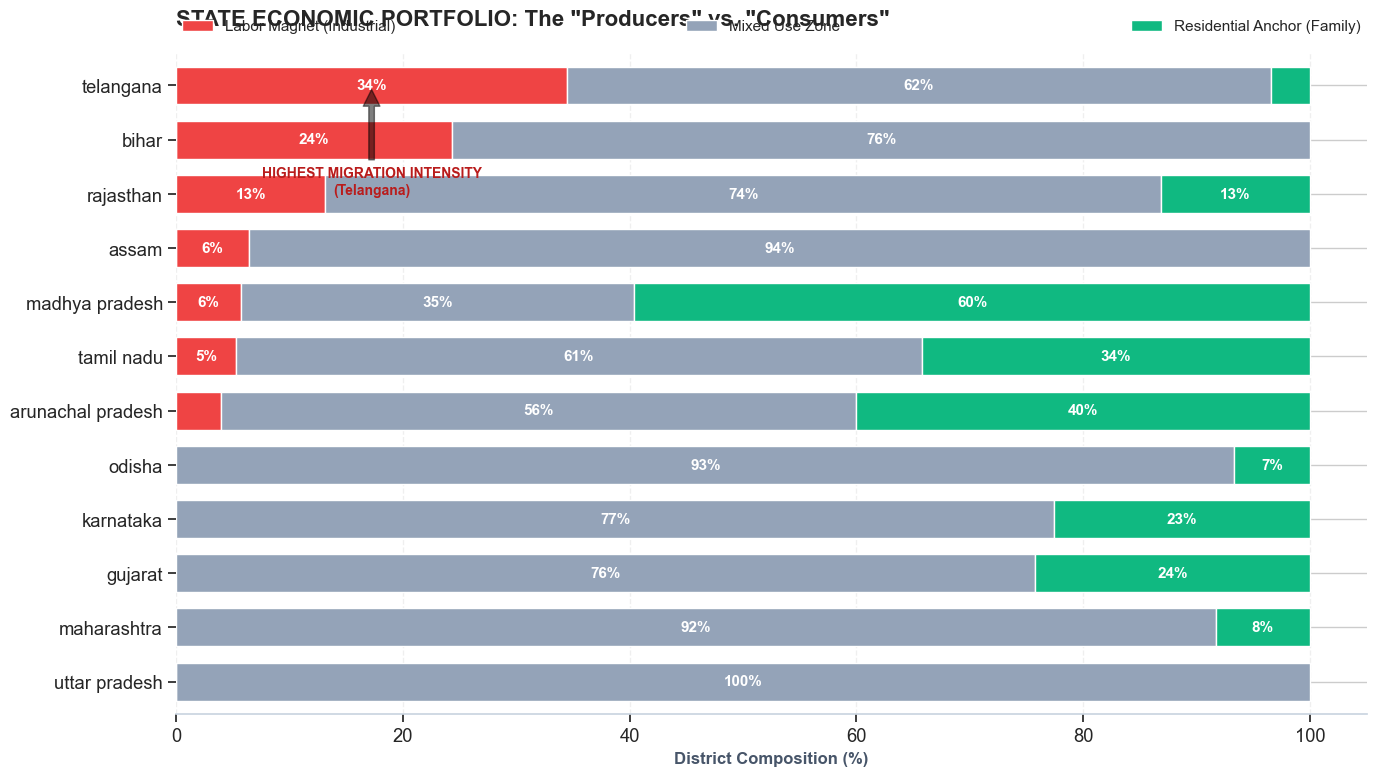

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_state_economic_portfolio(df):
    # 1. Prepare Data
    # Count zone types per state
    state_counts = df.groupby(['state', 'zone_type']).size().unstack(fill_value=0)
    
    # Calculate percentage
    state_pct = state_counts.div(state_counts.sum(axis=1), axis=0) * 100
    
    # Filter for significant states (Top 12 by total district count to ensure relevance)
    top_states = df['state'].value_counts().head(12).index
    plot_data = state_pct.loc[top_states]
    
    # CRITICAL STEP: Sort by 'Labor Magnet' percentage
    # This aligns the chart to show "Who is driving the economy?" at the top
    # We fill NaN with 0 to ensure sorting works if a column is missing
    if 'Labor Magnet (Industrial)' in plot_data.columns:
        plot_data = plot_data.sort_values('Labor Magnet (Industrial)', ascending=True)
    else:
        # Fallback if no labor magnets exist in top states
        plot_data = plot_data.sort_values(plot_data.columns[0], ascending=True)

    # 2. Setup Canvas (High-End Report Style)
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_facecolor('white') # Clean start
    
    # 3. Plot Stacked Bar
    # Using specific hex codes to match previous "Radar" chart
    colors = ['#ef4444', '#64748b', '#10b981'] # Red (Labor), Grey (Mixed), Green (Family)
    
    # Check if columns exist to map colors correctly (Safety check)
    col_order = ['Labor Magnet (Industrial)', 'Mixed Use Zone', 'Residential Anchor (Family)']
    # Ensure columns exist in data
    existing_cols = [c for c in col_order if c in plot_data.columns]
    plot_data = plot_data[existing_cols]
    
    # Map colors to the specific columns present
    color_map = {
        'Labor Magnet (Industrial)': '#ef4444', # Red
        'Mixed Use Zone': '#94a3b8',            # Cool Grey
        'Residential Anchor (Family)': '#10b981' # Green
    }
    current_colors = [color_map[c] for c in plot_data.columns]

    # Plot
    plot_data.plot(kind='barh', stacked=True, color=current_colors, width=0.7, ax=ax, edgecolor='white')

    # 4. Smart Annotation (The "Clean" Look)
    for c in ax.containers:
        # Custom label formatting: Only show label if value > 5%
        labels = [f'{v.get_width():.0f}%' if v.get_width() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=11)

    # 5. Styling & Narrative
    ax.set_title('STATE ECONOMIC PORTFOLIO: The "Producers" vs. "Consumers"', fontsize=16, fontweight='bold', pad=20, loc='left')
    ax.set_xlabel('District Composition (%)', fontsize=12, fontweight='bold', color='#475569')
    ax.set_ylabel('', fontsize=12) # Hide State Label (redundant)
    
    # Move Legend to top
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=3, frameon=False, fontsize=11)

    # Remove Chart Junk
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False) # Clean look
    ax.spines['bottom'].set_color('#cbd5e1')
    
    # Add vertical grid for readability
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    # 6. Insight Annotation (The "Wow" Factor)
    # Find the state with max Labor Magnet
    if 'Labor Magnet (Industrial)' in plot_data.columns:
        max_labor_state = plot_data['Labor Magnet (Industrial)'].idxmax()
        max_val = plot_data.loc[max_labor_state, 'Labor Magnet (Industrial)']
        
        # Add arrow pointing to the top red bar
        # Note: In a horizontal bar chart, y-coordinates are 0, 1, 2...
        y_pos = plot_data.index.get_loc(max_labor_state)
        ax.annotate(f'HIGHEST MIGRATION INTENSITY\n({max_labor_state.title()})', 
                    xy=(max_val/2, y_pos), xytext=(max_val/2, y_pos-2),
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.5),
                    fontsize=10, fontweight='bold', color='#b91c1c', ha='center')

    plt.tight_layout()
    plt.show()

# Run Visualization
plot_state_economic_portfolio(df_district_profile)

Visual Insight #3: The "Migration Season" By plotting the Labor Signal over time, we spot the exact months when migration surges. This informs when to deploy temporary registration camps.

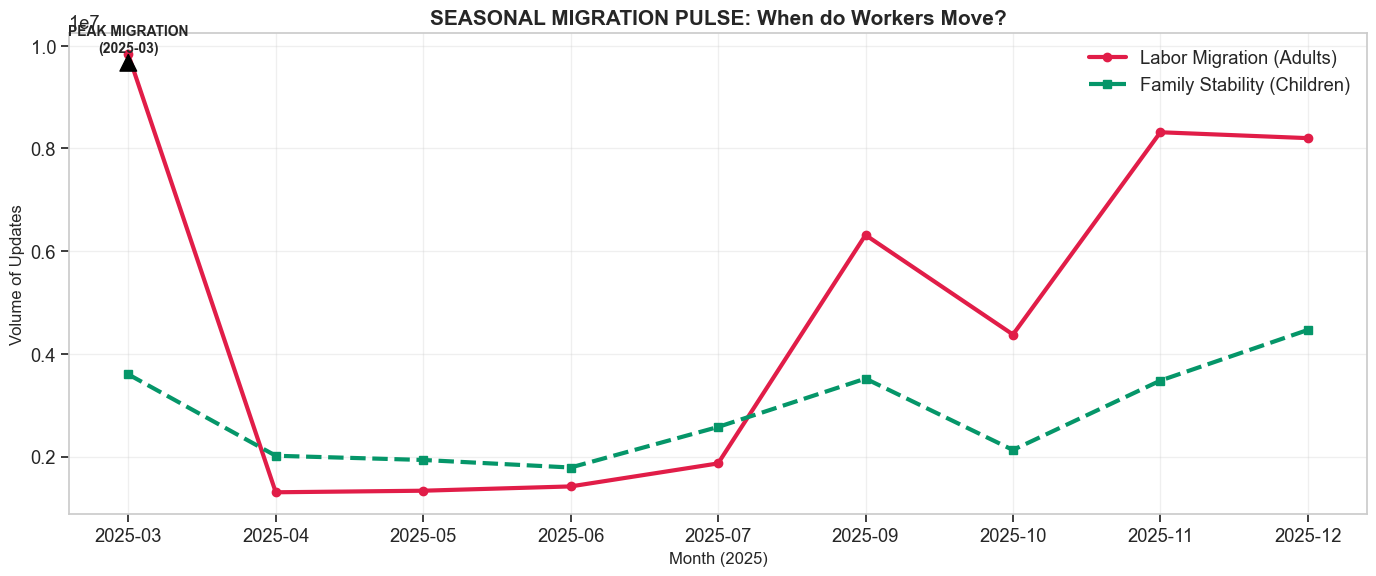

In [5]:
# 1. Group by Month to see national trends
df_seasonal = df_sentinel.groupby('month')[['labor_signal', 'family_signal']].sum()
df_seasonal.index = df_seasonal.index.astype(str) # Convert Period to String for plotting

# 2. Plot Line Chart
plt.figure(figsize=(14, 6))

# Plot Labor (Migration)
plt.plot(df_seasonal.index, df_seasonal['labor_signal'], 
         marker='o', color='#e11d48', linewidth=3, label='Labor Migration (Adults)')

# Plot Family (Stability)
plt.plot(df_seasonal.index, df_seasonal['family_signal'], 
         marker='s', color='#059669', linewidth=3, linestyle='--', label='Family Stability (Children)')

plt.title('SEASONAL MIGRATION PULSE: When do Workers Move?', fontsize=15, fontweight='bold')
plt.xlabel('Month (2025)', fontsize=12)
plt.ylabel('Volume of Updates', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight Peak Migration
peak_labor = df_seasonal['labor_signal'].max()
peak_month = df_seasonal['labor_signal'].idxmax()
plt.annotate(f'PEAK MIGRATION\n({peak_month})', xy=(peak_month, peak_labor), xytext=(peak_month, peak_labor+50000),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

🏛️ Strategic Output: The Infrastructure Matching Plan

We convert our data findings into specific policy mandates. This table prevents Infrastructure Mismatch (building schools where hostels are needed).

In [6]:
# 1. Define Recommendations based on Zone
def recommend_policy(row):
    if row['zone_type'] == 'Labor Magnet (Industrial)':
        return "PRIORITY: Rental Housing, Night Clinics, Transport Hubs"
    elif row['zone_type'] == 'Residential Anchor (Family)':
        return "PRIORITY: Schools, Pediatric Wards, Parks"
    else:
        return "MAINTAIN: Standard Urban Infrastructure"

df_district_profile['Policy_Action'] = df_district_profile.apply(recommend_policy, axis=1)

# 2. Create High-Value Report Table
# Selecting top 5 examples of each for the report
report_magnets = df_district_profile[df_district_profile['zone_type'] == 'Labor Magnet (Industrial)'].nlargest(3, 'mobility_ratio')
report_anchors = df_district_profile[df_district_profile['zone_type'] == 'Residential Anchor (Family)'].nsmallest(3, 'mobility_ratio')

final_report = pd.concat([report_magnets, report_anchors])

# 3. Export Final Plan
df_district_profile[['state', 'district', 'mobility_ratio', 'zone_type', 'Policy_Action']].to_csv('policy_action_plan.csv', index=False)

print("\n--- GOVERNANCE ACTION PLAN (Sample) ---")
display_cols = ['district', 'state', 'zone_type', 'Policy_Action']
pd.set_option('display.max_colwidth', None)
print(final_report[display_cols].to_string(index=False))

print("\nFull Policy Plan exported to 'policy_action_plan.csv'")


--- GOVERNANCE ACTION PLAN (Sample) ---
    district             state                   zone_type                                           Policy_Action
     balotra         rajasthan   Labor Magnet (Industrial) PRIORITY: Rental Housing, Night Clinics, Transport Hubs
        deeg         rajasthan   Labor Magnet (Industrial) PRIORITY: Rental Housing, Night Clinics, Transport Hubs
     phalodi         rajasthan   Labor Magnet (Industrial) PRIORITY: Rental Housing, Night Clinics, Transport Hubs
kurung kumey arunachal pradesh Residential Anchor (Family)               PRIORITY: Schools, Pediatric Wards, Parks
       mamit           mizoram Residential Anchor (Family)               PRIORITY: Schools, Pediatric Wards, Parks
      ramban jammu and kashmir Residential Anchor (Family)               PRIORITY: Schools, Pediatric Wards, Parks

Full Policy Plan exported to 'policy_action_plan.csv'


C:\Users\kisho\AppData\Local\Temp\ipykernel_53152\2262537545.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(abs(x)/1000)}k' for x in ticks])


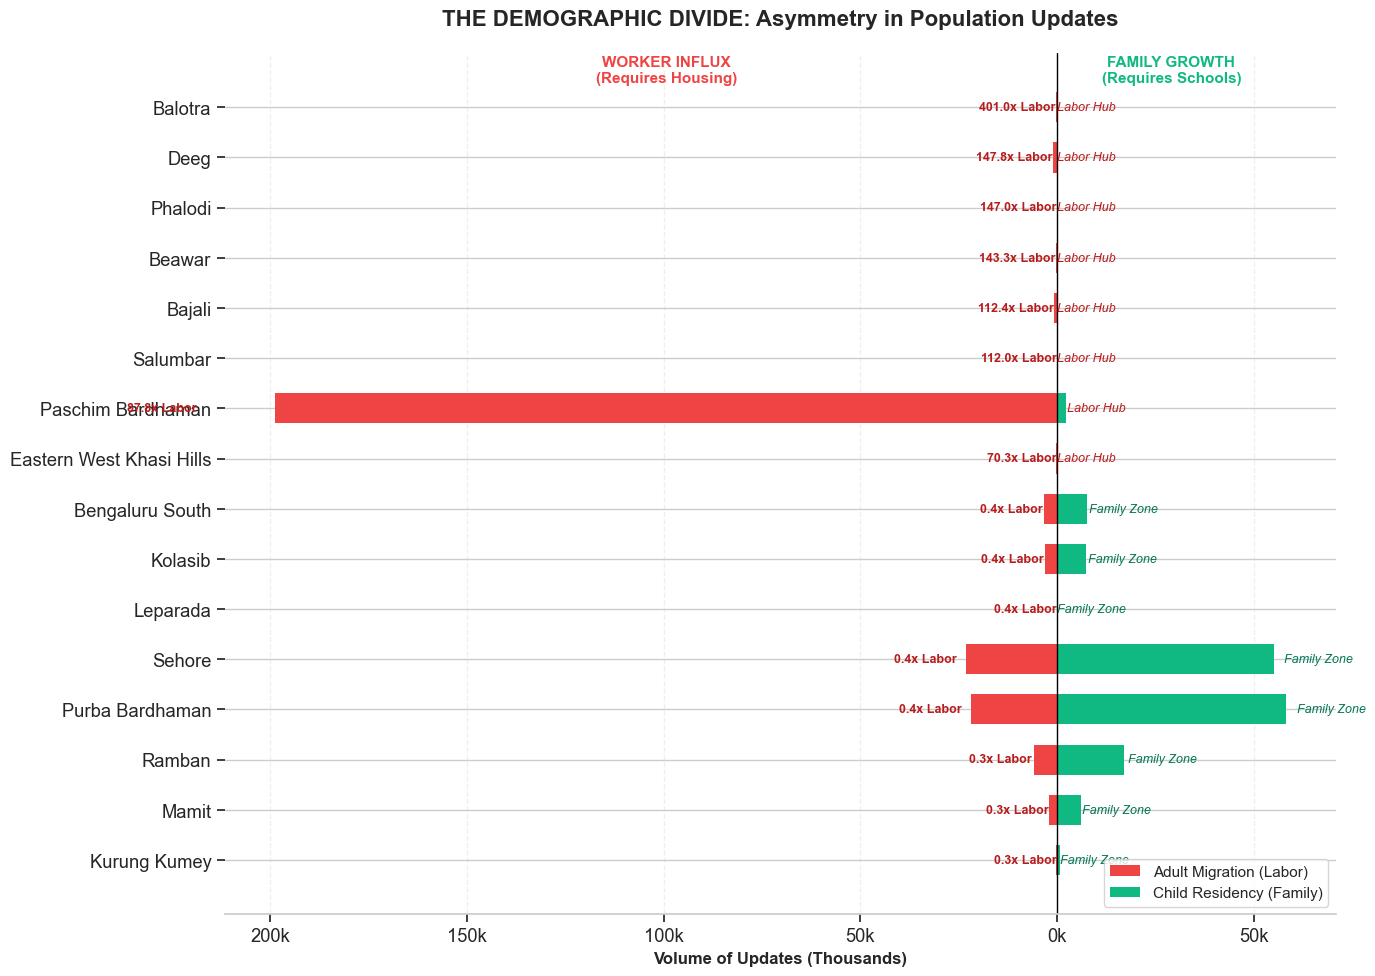

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_demographic_butterfly(df):
    # 1. Prepare Data
    # We want to contrast the Top 10 "Labor Magnets" vs Top 10 "Residential Anchors"
    # to show the extreme difference in their "shape"
    magnets = df[df['zone_type'] == 'Labor Magnet (Industrial)'].nlargest(8, 'mobility_ratio')
    anchors = df[df['zone_type'] == 'Residential Anchor (Family)'].nsmallest(8, 'mobility_ratio')
    
    # Combine and sort for the plot
    df_chart = pd.concat([magnets, anchors])
    # Sort by Mobility Ratio so Red is at top, Green at bottom
    df_chart = df_chart.sort_values('mobility_ratio', ascending=True)

    # 2. Setup Canvas
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_facecolor('white')

    # 3. Create the "Wings"
    # Left Wing: Labor Signal (Make negative to plot on left)
    ax.barh(df_chart['district'].str.title(), -df_chart['labor_signal'], color='#ef4444', height=0.6, label='Adult Migration (Labor)')
    
    # Right Wing: Family Signal (Positive to plot on right)
    ax.barh(df_chart['district'].str.title(), df_chart['family_signal'], color='#10b981', height=0.6, label='Child Residency (Family)')

    # 4. Format the Axis (Remove negative signs)
    # We want the numbers to look positive on both sides
    ticks = ax.get_xticks()
    ax.set_xticklabels([f'{int(abs(x)/1000)}k' for x in ticks])

    # 5. Smart Annotations (The Central Spine)
    # We place the district names in the middle or slightly offset
    # Actually, standard y-axis labels work well here if the split is clear.
    
    # Add Ratio Labels on the ends
    for i, row in enumerate(df_chart.itertuples()):
        # Left Label (Ratio)
        ax.text(-row.labor_signal - (row.labor_signal*0.1), i, 
                f"{row.mobility_ratio:.1f}x Labor", 
                va='center', ha='right', color='#b91c1c', fontweight='bold', fontsize=9)
        
        # Right Label (Type)
        ax.text(row.family_signal + (row.family_signal*0.05), i, 
                "Family Zone" if row.mobility_ratio < 1 else "Labor Hub", 
                va='center', ha='left', color='#047857' if row.mobility_ratio < 1 else '#b91c1c', 
                fontsize=9, style='italic')

    # 6. Center Line
    ax.axvline(0, color='black', linewidth=1, linestyle='-')

    # 7. Styling
    ax.set_title('THE DEMOGRAPHIC DIVIDE: Asymmetry in Population Updates', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Volume of Updates (Thousands)', fontsize=12, fontweight='bold')
    
    # Remove top/right/left spines
    sns.despine(left=True, bottom=False)
    
    # Grid
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Legend
    plt.legend(loc='lower right', fontsize=11, frameon=True)
    
    # 8. Add "Insight Arrows"
    # Arrow pointing Left
    plt.text(-df_chart['labor_signal'].max()*0.5, len(df_chart)-0.5, "WORKER INFLUX\n(Requires Housing)", 
             color='#ef4444', ha='center', fontweight='bold', fontsize=11)
    # Arrow pointing Right
    plt.text(df_chart['family_signal'].max()*0.5, len(df_chart)-0.5, "FAMILY GROWTH\n(Requires Schools)", 
             color='#10b981', ha='center', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

# Run Visualization
plot_demographic_butterfly(df_district_profile)